# PlaygroundML
---
# 6. Gaussian Mixture Models

In [2]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt

from gmm import GaussianMixtureModel
import sklearn.mixture as mix

# Set latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 6.1 Latent Variable Models

Here we illustrate how latent variables can be used to model data. We use the example of a multivariate Gaussian distribution. We first sample from a 2D Gaussian distribution with a fixed covariance matrix, and then we sample from a 2D Gaussian distribution with uncorrelated noise and a mean that depends on a latent variable.

The two example models are as follows:
$$\mathbf{x}\sim\mathcal{N}\left(
    \mathbf{0},
    \begin{bmatrix}
        3 & 2\\
        2 & 3
    \end{bmatrix}
\right)  
\quad  
\iff
\quad
z\sim\mathcal{N}(0,1) \qquad \mathbf{x}\sim\mathcal{N}\left(
    \sqrt{2}
    \begin{bmatrix}
        1\\
        1
    \end{bmatrix}
    z,
    \begin{bmatrix}
        1 & 0\\
        0 & 1
    \end{bmatrix}
\right)
$$

where $z$ is a latent variable. These two models are sampled from below.

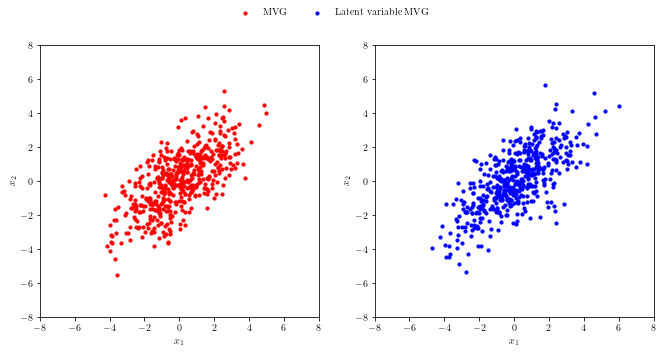

In [3]:
# Multivariate Gaussian using a given covariance matrix
mean_1 = np.array([0,0])
cov_1 = np.array([[3,2],[2,3]])
x1 = np.random.multivariate_normal(mean_1, cov_1, size=500)

# Multivariate Gaussian using latent variable
def latent_sampler(size):
    samples = np.zeros((size, 2))
    cov = np.identity(2)

    for i_sample in range(size):
        mean = np.ones(2) * np.sqrt(2) * np.random.normal()
        samples[i_sample,:] = np.random.multivariate_normal(mean, cov)

    return samples

x2 = latent_sampler(size=500)


# Plot samples for both models
fig, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(x1[:,0], x1[:,1], color='r', s=10.0, label='MVG')
axes[1].scatter(x2[:,0], x2[:,1], color='b', s=10.0, label='Latent variable MVG')
for ax in axes:
    ax.set_xlim(-8,8)
    ax.set_ylim(-8,8)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
fig.legend(loc='upper center', ncols=2, frameon=False)
plt.show()

From the plots above it is clear to see that these are equivalent models.

## 6.2 Expectation Maximisation

### 6.2.1 Generate Data

A general $K$-component mixture model is defined as follows:
$$
    p(\mathbf{x}) = \sum_{k=1}^K \pi_k p(\mathbf{x}|\mathbf{\theta}_k), \qquad \sum_{k=1}^K \pi_k = 1
$$
where $\pi_k$ is the mixing coefficient for the $k^{th}$ component, and $\mathbf{\theta}_k$ are the parameters of the $k^{th}$ component. In the case of a Gaussian mixture model, the components are multivariate Gaussian distributions, and the parameters are the means and covariances of the components:
$$
p(\mathbf{x}|\mathbf{\theta}_k) = \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k,\mathbf{\Sigma}_k)
$$

We wish to fit a Gaussian mixture model to a toy dataset using the *Expectation Maximisation (EM)* algorithm. We first generate the data.

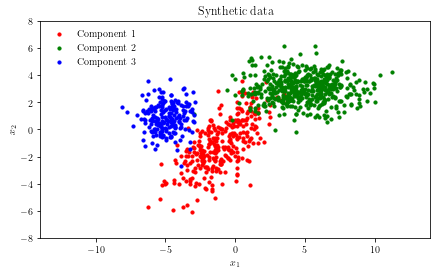

In [4]:
# Generate samples from a mixture of Gaussians
true_pi = np.array([0.3, 0.5, 0.2])
true_means = np.array([[-1, -1], 
                       [5, 3], 
                       [-5, 1]])
true_covs = np.array([[[3, 2], [2, 3]],
                      [[5, 0], [0, 1]],
                      [[1, 0], [0, 1]]])
colours = ['r', 'g', 'b']

# Generate samples
n_samples = 1000
x = np.zeros((n_samples,2))
labels = np.zeros(n_samples)

for i_sample in range(n_samples):
    # Choose a component
    z = np.random.choice([0,1,2], p=true_pi)

    # Sample from the chosen component
    x[i_sample,:] = np.random.multivariate_normal(true_means[z,:], true_covs[z,:,:])
    labels[i_sample] = z

# Plot samples
plt.figure(figsize=(7,4))
for i in range(3):
    plt.scatter(x[labels==i,0], x[labels==i,1], color=colours[i], s=10.0, label=f'Component {i+1}')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-14,14)
plt.ylim(-8,8)
plt.legend(frameon=False, loc='upper left')
plt.title('Synthetic data')
plt.show()



### 6.2.2 Fit Gaussian Mixture Model with the EM Algorithm

The EM algorithm operates by maximising the *free energy* $\mathcal{F}(q,\theta)$, with respect to the parameters $\theta$ and the distribution $q(\mathcal{Z})$ over the latent variables $\mathcal{Z}$, where $\mathcal{Z}$ is the set of all latent variables. The free energy is defined as follows:
$$
    \mathcal{F}(q,\theta) = \mathbb{E}_{q(\mathcal{Z})}\left[\log P(\mathcal{X},\mathcal{Z}|\theta)\right] - \mathbb{E}_{q(\mathcal{Z})}\left[\log q(\mathcal{Z})\right]
$$
where $\mathcal{X}$ is the set of all observed variables. The free energy is a lower bound on the log-likelihood of the data, and so maximising the free energy can be used as a proxy for maximising the log-likelihood. The general EM algorithm is as follows:

1. Initialise the parameters of the model.
2. **E-step**: Compute the posterior distribution of the latent variables given the data and the current parameters.
$$
    q^{(k)}(\mathcal{Z}) = \underset{q(\mathcal{Z})}{\text{argmax}}\:\mathcal{F}(q(\mathcal{Z}),\theta^{(k-1)}) = P(\mathcal{Z}|\mathcal{X},\theta^{(k-1)})
$$
3. **M-step**: Compute the parameters that maximise the expected log-likelihood found in the E-step.
$$
    \theta^{(k)} = \underset{\theta}{\text{argmax}}\:\mathcal{F}(q^{(k)}(\mathcal{Z}),\theta) = \underset{\theta}{\text{argmax}}\:\mathbb{E}_{q^{(k)}(\mathcal{Z})}\left[\log P(\mathcal{X},\mathcal{Z}|\theta)\right]
$$
4. Repeat steps 2 and 3 until convergence.

For the Gaussian mixture model, the E-step is as follows:
$$
    q^{(k)}(\mathcal{Z}) = P(\mathcal{Z}|\mathcal{X},\theta^{(k-1)}) = \frac{P(\mathcal{X},\mathcal{Z}|\theta^{(k-1)})}{P(\mathcal{X}|\theta^{(k-1)})} = \frac{P(\mathcal{X},\mathcal{Z}|\theta^{(k-1)})}{\sum_{\mathcal{Z}}P(\mathcal{X},\mathcal{Z}|\theta^{(k-1)})}
$$
Thus, we can conduct the E-step by computing the *responsibilities* $r_{nk}$, which are the posterior probabilities of the latent variables $z_k$ given the data $\mathcal{X}$ and the current parameters $\theta$:
$$
    r_{nk} \gets P(z_k|\mathbf{x}_n,\theta) = \frac{P(\mathbf{x}_n,z_k|\theta)}{\sum_{j=1}^K P(\mathbf{x}_n,z_j|\theta)} = \frac{\pi_k\mathcal{N}(\mathbf{x}_n|\mathbf{\mu}_k,\Sigma_k)}{\sum_{j=1}^K \pi_j\mathcal{N}(\mathbf{x}_n|\mathbf{\mu}_j,\Sigma_j)}
$$
where $\mathbf{x}_n$ is the $n^{th}$ data point. For the Gaussian mixture model, the M-step updates are computed by setting the derivatives of the free energy with respect to the parameters to zero. The M-step updates for the Gaussian mixture model are as follows:
$$
    \mathbf{\mu}_k \gets \frac{\sum_{n=1}^N r_{nk}\mathbf{x}_n}{\sum_{n=1}^N r_{nk}} \qquad \mathbf{\Sigma}_k \gets \frac{\sum_{n=1}^N r_{nk}(\mathbf{x}_n-\mathbf{\mu}_k)(\mathbf{x}_n-\mathbf{\mu}_k)^\top}{\sum_{n=1}^N r_{nk}} \qquad \pi_k \gets \frac{\sum_{n=1}^N r_{nk}}{N}
$$
where $N$ is the number of data points. Below we run the EM algorithm on the toy dataset, using my own implementation, `GaussianMixtureModel()`, and the implementation from `sklearn.mixture.GaussianMixture()`.

Pi: 
 [0.19675854 0.49812908 0.30511238]

Means: 
 [[-4.93073048  0.91322763]
 [ 4.85614444  3.03052058]
 [-0.98369357 -1.04300612]]

Covariances: 
 [[[ 1.03518899  0.05313956]
  [ 0.05313956  1.01935525]]

 [[ 4.40759494 -0.01976103]
  [-0.01976103  0.94311816]]

 [[ 3.40294863  2.47215445]
  [ 2.47215445  3.7634826 ]]]



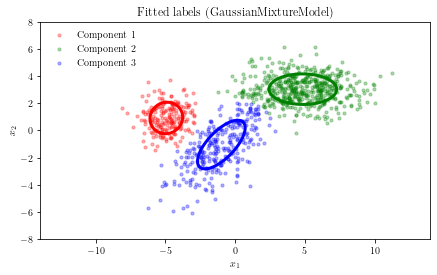

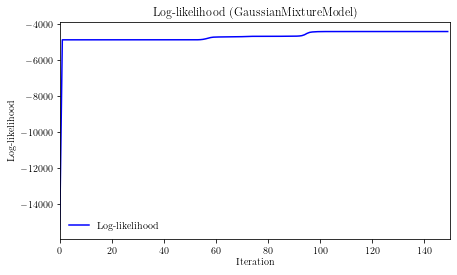

In [6]:
# Set parameters of model
n_components = 3
d = 2 # dimensionality of data
n_iter = 150

GMM = GaussianMixtureModel(n_components, d)
GMM.fit(x, n_iter)
print(f'Pi: \n {GMM.pi}\n')
print(f'Means: \n {GMM.means}\n')
print(f'Covariances: \n {GMM.covariances}\n')

fitted_labels = np.argmax(GMM.responsibilities, axis=1)

# Plot data with fitted labels
plt.figure(figsize=(7,4))
for i in range(n_components):
    plt.scatter(x[fitted_labels==i,0], x[fitted_labels==i,1], color=colours[i], s=10.0, label=f'Component {i+1}', alpha=0.3)

# Plot single contour of fitted Gaussians
x1 = np.linspace(-14,14,100)
x2 = np.linspace(-8,8,100)
X1, X2 = np.meshgrid(x1, x2)
X = np.array([X1.ravel(), X2.ravel()]).T

for i in range(n_components):
    Z = GMM.gaussian(X, GMM.means[i,:], GMM.covariances[i,:,:])
    Z = Z.reshape(X1.shape)
    plt.contour(X1, X2, Z, colors=colours[i], levels=1, linewidths=3)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-14,14)
plt.ylim(-8,8)
plt.legend(frameon=False, loc='upper left')
plt.title('Fitted labels (GaussianMixtureModel)')
# plt.savefig('GMM_fitted_labels.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Plot log-likelihood
plt.figure(figsize=(7,4))
plt.plot(GMM.loglikes, color='b', label='Log-likelihood')
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood (GaussianMixtureModel)')
plt.xlim(0,n_iter)
plt.legend(frameon=False)
# plt.savefig('GMM_loglike.pdf', dpi=600, bbox_inches='tight')
plt.show()

The free energy always increases with each EM iteration, which is confirmed by our plot above.

Pi: 
 [0.31620764 0.19848911 0.48530325]

Means: 
 [[-0.84885105 -0.89176017]
 [-4.9165309   0.89883596]
 [ 4.93089093  3.03854118]]

Covariances: 
 [[[ 3.67338876  2.84584043]
  [ 2.84584043  4.23365319]]

 [[ 1.05573377  0.03279636]
  [ 0.03279636  1.04276279]]

 [[ 4.25904828 -0.05563851]
  [-0.05563851  0.92997562]]]



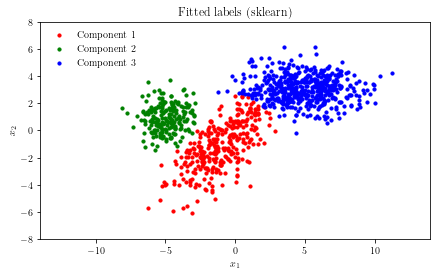

In [7]:
# Sklearn implementation
GMM_sklearn = mix.GaussianMixture(n_components, covariance_type='full', max_iter=n_iter)
GMM_sklearn.fit(x)
print(f'Pi: \n {GMM_sklearn.weights_}\n')
print(f'Means: \n {GMM_sklearn.means_}\n')
print(f'Covariances: \n {GMM_sklearn.covariances_}\n')

fitted_labels_sklearn = GMM_sklearn.predict(x)

# Plot data with fitted labels
plt.figure(figsize=(7,4))
for i in range(n_components):
    plt.scatter(x[fitted_labels_sklearn==i,0], x[fitted_labels_sklearn==i,1], color=colours[i], s=10.0, label=f'Component {i+1}')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-14,14)
plt.ylim(-8,8)
plt.legend(frameon=False, loc='upper left')
plt.title('Fitted labels (sklearn)')
plt.show()

Both implementations above correctly identify the three clusters. Comparing with the initial plot of the synthetic data, there are a few points that have been misclassified; these are typically the points that lie on the boundary between two clusters. Our algorithm simply classifies a point based on which cluster it is most likely to belong to, so there are inevitably some cases where it is not clear which cluster a point belongs to.

Below we plot the EM algorithm's progress as it fits the Gaussian mixture model to the toy dataset.

MovieWriter imagemagick unavailable; using Pillow instead.


[[-5.03981172  0.99235037]
 [ 5.11279424  2.94720552]
 [-0.95551526 -1.07800038]]


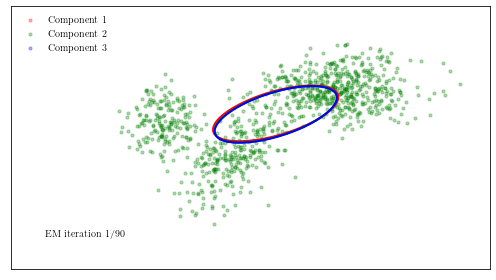

In [53]:
# Code to produce animated gif
import matplotlib.animation as animation

n_iter = 90
n_burnin = 60

GMM = GaussianMixtureModel(n_components, d)
GMM.fit_iterations(x, n_iter+n_burnin)

resp_trunc = GMM.resp_hist[n_burnin:]
means_trunc = GMM.means_hist[n_burnin:]
covs_trunc = GMM.covariances_hist[n_burnin:]

print(GMM.means_hist[-1])

def EM_iteration(i):
    fitted_labels = np.argmax(resp_trunc[i], axis=1)
    # print(fitted_labels)
    plt.cla()
    for j1 in range(n_components):
        plt.scatter(x[fitted_labels==j1,0], x[fitted_labels==j1,1], color=colours[j1], s=10.0, label=f'Component {j1+1}', alpha=0.3)

    x1 = np.linspace(-14,14,100)
    x2 = np.linspace(-8,8,100)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.array([X1.ravel(), X2.ravel()]).T


    for j2 in range(n_components):
        Z = GMM.gaussian(X, means_trunc[i][j2,:], covs_trunc[i][j2,:,:])
        Z = Z.reshape(X1.shape)
        plt.contour(X1, X2, Z, colors=colours[j2], levels=1, linewidths=2)  

    plt.legend(frameon=False, loc='upper left')
    plt.xticks([])
    plt.yticks([])
    plt.text(-12, -6, f'EM iteration {i+1}/{n_iter}')
    plt.tight_layout()



fig = plt.figure(figsize=(7,4))

# Set up contour plot
plt.xlim(-14,14)
plt.ylim(-8,8)

anim = animation.FuncAnimation(fig, EM_iteration, frames=n_iter, interval=100)
 
# Save gif
anim.save('GMM_EM.gif', dpi=400, fps=25, writer='imagemagick')

## 6.3 $k$-Means Clustering